# Imports

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import os
import time
from datetime import datetime

from threading import Thread
import IPython
import IPython.display

import numpy as np
from math import *

import tensorflow as tf
from tensorflow.keras.layers import LSTM, LeakyReLU ,Flatten , Dense,Dropout
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

import matplotlib.pyplot as plt
from pltfigure import pltfigure

In [31]:
print(tf.__version__)

2.8.0


In [32]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
tf.test.is_built_with_cuda()

1 Physical GPUs, 1 Logical GPUs


True

In [33]:
tf.executing_eagerly()

True

# DATASET

In [34]:
InputData = np.genfromtxt('Data/InputDataBenchmark.csv',delimiter=",")
t = np.genfromtxt('Data/timeBenchmark.csv',delimiter=",")
Data = np.genfromtxt('Data/OutputDataBenchmark.csv',delimiter=",")
print(f"OutData: %s, \nInputData: %s, \nTime: %s" %(np.shape(Data),np.shape(InputData),np.shape(t)))

OutData: (400, 28), 
InputData: (28, 6), 
Time: (400,)


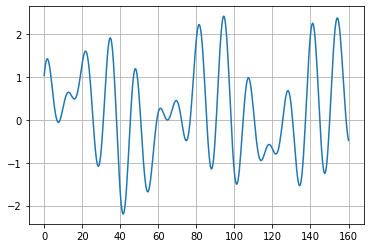

In [35]:
example_ind = 5

plt.plot(t,Data[:,example_ind])
plt.grid()

In [36]:
InputData.shape

(28, 6)

# Simple Pipeline

In [37]:
from InputPipeline import SimplePipeline

## Apply Pipeline to make Data

In [38]:
pipe = SimplePipeline(num_samples=np.shape(InputData)[0], n_steps=20, xshape=np.shape(t)[0],val_cases = 2,use_metadata=True)
x_inp, y_out= pipe.makeData(data=Data.T,metadata=InputData)
print(f"Input X Shape: {x_inp.shape}")
print(f"Output Y Shape: {y_out.shape}")
print(f"Metadata Added Shape: {InputData.shape}")

Input X Shape: (10640, 26)
Output Y Shape: (10640,)
Metadata Added Shape: (28, 6)


## Plot Data

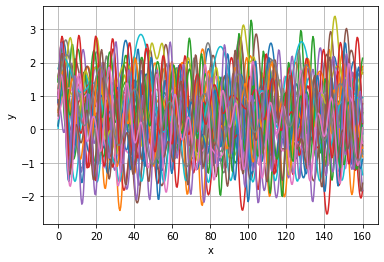

In [39]:
pipe.plotAlldata(Data.T,t)

## Split Data

In [40]:
x_inp_train ,y_out_train ,x_inp_val  ,y_out_val = pipe.split_data(x_inp,y_out)
print(x_inp_train.shape, y_out_train.shape, x_inp_val.shape, y_out_val.shape)

(10584, 26) (10584,) (56, 26) (56,)


# Window Input Pipeline
Much More Memory Efficient (100x)

In [41]:
from InputPipeline import WindowGenerator,DataPipeline

## Split The Data

You'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons:

    It ensures that chopping the data into windows of consecutive samples is still possible.
    It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.


In [42]:
pipe2 = DataPipeline(Data,InputData)
pipe2.splitData(0.8,0.1,0.1)

## Normalize Data

In [ ]:
pipe2.normalizeData()

In [ ]:
plt.plot(t,pipe2.train_df[:,example_ind])
plt.grid()
plt.show()

# Data Windowing

### Example of window

In [ ]:
wExample = WindowGenerator(input_width=30, label_width=1, shift=1,
                            train_df=pipe2.train_df,val_df=pipe2.val_df,test_df=pipe2.test_df, 
                            batch_size=5,
                            md_train_df =pipe2.meta_train_df, md_test_df =pipe2.meta_test_df,md_val_df=pipe2.meta_val_df)
wExample

### Create tf.data.Datasets

In [ ]:
wExample.make_dataset(data=pipe2.train_df,added_data=pipe2.meta_train_df).element_spec

### Plot/Example

In [ ]:
wExample.plotexample()
print(f'Inputs shape (Batchsize, timesteps,features): {wExample.example[1].shape}')
print(f'Labels shape (Batchsize, timesteps,features): {wExample.example[0].shape}')


### Plot Particular

In [ ]:
OUT_STEPS = 30
wExample2 = WindowGenerator(input_width=30, label_width=OUT_STEPS,
                            shift=OUT_STEPS, train_df=pipe2.train_df, val_df=pipe2.val_df, test_df=pipe2.test_df,batch_size=5,
                            md_train_df =pipe2.meta_train_df, md_test_df =pipe2.meta_test_df,md_val_df=pipe2.meta_val_df)


In [ ]:
wExample2.plotCase(pipe2.train_df[:,3],t)

# LSTM MODEL 1 TimeStep Train

In [43]:
def compile_and_fit(model, name, window, patience=10, MAX_EPOCHS=500, record=True):

    now = datetime.now()
    dt_string = now.strftime("%d-%m-%Y-%H-%M")

    NAME = name + "@"+str(MAX_EPOCHS)+"@"+dt_string
    filename = os.path.join("Models",  NAME + '.h5')
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    if record == True:
        tensorboard = TensorBoard(log_dir= os.path.join("logs",NAME))
        checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=0,
                                     save_best_only=True, mode='min', save_weights_only=True)
        callbacks = [early_stopping, tensorboard, checkpoint]
    else:
        callbacks = [early_stopping]

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=callbacks)  # ,tensorboard,checkpoint])
    return history


val_performance = {}
performance = {}


In [45]:
from network import lstm_benchmark_model
model = lstm_benchmark_model(units = 64)

In [46]:
windowOneStep = WindowGenerator(
    input_width=30, label_width=1, shift=1,
    train_df=pipe2.train_df,test_df=pipe2.test_df,val_df=pipe2.val_df,
    batch_size = 1000,
    md_train_df =pipe2.meta_train_df, md_test_df =pipe2.meta_test_df,md_val_df=pipe2.meta_val_df)

print(windowOneStep)

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]


In [47]:
windowOneStep.example[0].shape

TensorShape([1000, 36, 1])

In [48]:
model = lstm_benchmark_model(units = 64)
print('Input shape:', windowOneStep.example[0].shape)
print('Output shape:', model(windowOneStep.example[0]).shape)

Input shape: (1000, 36, 1)
Output shape: (1000, 1)


In [ ]:
model.summary()

In [ ]:
%%time
history = compile_and_fit(model, "BenchmarkLSTM",windowOneStep,MAX_EPOCHS=800 ,patience = 30,record = True)

IPython.display.clear_output()

val_performance['LSTM'] = model.evaluate(windowOneStep.val)
performance['LSTM'] = model.evaluate(windowOneStep.test, verbose=0)

# Plotting Results

Example Plotting

In [ ]:
windowOneStep.plotexample(model)

Plotting Specific Case at Specific Time

In [ ]:
startTime = 200
exampleCase = 1
CaseParameters = InputData[exampleCase]
print("W: {}\nZ: {}\nX0: {}\nV0: {}".format(*CaseParameters))
pred = windowOneStep.plotCase( val_df[:, exampleCase],t, model=model,metadata=InputData[exampleCase],
                               options = {"showLines" : False,  "yLabel" :'x', "xLabel" :'Timesteps'})

# Try to produce TimeSeries

In [ ]:
def CalcCase(data, window, model,metadata = None):
    inputs = data[:window.input_width]
    inputsRT = data[:window.input_width]
    if metadata is not None:
        inputs = np.hstack([inputs,metadata])
        inputsRT = np.hstack([inputsRT,metadata])
    outputs = data[:window.input_width]
    outputsRT = data[:window.input_width]
    
    shift = window.shift
    for i, time in enumerate(t[window.input_width::shift]):
        pred = np.squeeze(model(np.reshape(inputs, (1, inputs.shape[0], 1))))
        predRT = np.squeeze(model(np.reshape(inputsRT, (1, inputsRT.shape[0], 1))))

        outputs = np.hstack([outputs, pred])
        outputsRT = np.hstack([outputsRT, predRT])

        inputs = data[i:i+window.input_width]
        inputsRT = outputsRT[-window.input_width:]
        if metadata is not None:
            inputsRT = np.hstack([inputsRT,metadata])
            inputs = np.hstack([inputs,metadata])

    return outputs, outputsRT

In [ ]:
predData = []
predDataRT = []
for i in range(val_df.shape[1]):
    print(i)
    testCase = val_df[:,i]
    testMetaData = InputData[i,:]
    ts1 ,ts2 = CalcCase(testCase,windowOneStep,model,metadata=testMetaData)
    predData.append(ts1)
    predDataRT.append(ts2)
predData = np.array(predData)
predDataRT = np.array(predDataRT)


# Plot Individually

In [ ]:
def plotCase(outputs, outputsRT, window, data, index):
    fig = plt.figure()
    axes = fig.add_axes([0, 0, 1, 1])
    iw = window.input_width

    axes.plot(t[:iw], data[:iw], label="Input", linewidth=1.5)
    axes.plot(t[iw:], data[iw:], label="Target", linestyle="dotted",linewidth=1.5)
    axes.plot(t[iw:], outputs[iw:], label="AR Predictions", 
                c='#2ca02c',linewidth = 1)
    axes.plot(t[iw:], outputsRT[iw:], label='Predictions',
                c='#ff7f0e',linewidth = 1)

    axes.grid()
    axes.legend()
    axes.set_title("Test Case")
    extent=axes.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig("Graphs/Agogos" + str(index) + '.png',
                dpi = 1000)
    plt.show()

In [ ]:
ts1 ,ts2 = CalcCase(val_df[:,3],windowOneStep,model,metadata=meta_val_df[3,:])
plotCase(ts1,ts2,windowOneStep,testCase,i)

# Produce Animation

In [ ]:
from pltfigure import pltfigure

In [ ]:
pltfigure(val_df.T,predData,t,"Data","Prediction",'Graphs/BenchmarkPred.gif')
pltfigure(val_df.T,predDataRT,t,"Data","Prediction",'Graphs/BenchmarkPredRT.gif')